# X. Polarized Rendering

## Overview

In spirit, this example is similar to [Tutorial 1](01_first_render.ipynb) but we'll highlight a few things to keep in mind regarding polarization-aware rendering in Mitsuba 2. 🕶

<div class="alert alert-block alert-info">
    
✔️ **What will you learn?**
    
<ul>
  <li>Build a scene with polarization support in mind.</li>
  <li>Render a scene and output the complete polarization state of light.</li>
  <li>Visualize the output.</li>
</ul>
    
</div>

### Step 1 - Choose a variant with polarization support

We first import the necessary packages:

In [1]:
# Add mitsuba and drjit to PATH (this shouldn't be necessary)
import sys
sys.path.append('../../build/python')


import drjit as dr
import mitsuba as mi

Many of the variants in Mitsuba 2 can additionally be configured to use polarization-aware rendering. For this simple example we stick to the scalar version based on a spectral color representation which is a good default choice.

Please see the documentation (**TODO** link) for details concerning other variants.

In [2]:
mi.set_variant('scalar_spectral_polarized')

ImportError: Requested an unsupported variant "scalar_spectral_polarized". The following variants are available: scalar_rgb, scalar_spectral, cuda_ad_rgb, llvm_ad_rgb, scalar_mono_polarized, llvm_ad_spectral.

### Step 2 - loading a scene from disk

Here we load a variation of the famous Cornell box scene that includes a few glass and metal spheres. These types of materials polarize light that interacts with them and thus it makes for a more interesting test scene.

In [3]:
scene = mi.load_file('../scenes/cbox_pol.xml')

2022-02-08 11:41:39 INFO main [xml.cpp:1260] Loading XML file "../scenes/cbox_pol.xml" with variant "scalar_spectral_polarized"..

2022-02-08 11:41:39 INFO main [srgb.cpp:22] Loading spectral upsampling model "data/srgb.coeff" ..

2022-02-08 11:41:39 INFO main [Scene] Embree ready. (took 15ms)

2022-02-08 11:41:39 INFO main [xml.cpp:1319] Done loading XML file "../scenes/cbox_pol.xml" (took 50ms).

There are a few noteworthy parts of the `.xml` scene description:

**1**. The path tracer integrator is wrapped inside the `stokes` integrator which means the renderer will output a multichannel image that includes the complete polarization state of the light arriving at the camera, encoded as a Stokes vector (**TODO** doc link).

```
<integrator type="stokes">
    <integrator type='path'/>
</integrator>
```

**2**. The interpretation of Stokes vectors makes most sense when rendering at a specific wavelength of light. The material descriptions are therefore specified to use constant spectra, ultimately resulting in a monochromatic output image.<br><br>For instance, the reflectance of the diffuse surfaces:
```
<bsdf type="diffuse" id="white">
    <rgb name="reflectance" value="0.8"/>
</bsdf>
```
or the complex refractive index of the metal, in this case representing a gold material at 600nm:
```
<bsdf type="conductor" id="metal">
    <spectrum name="eta" value="0.24873"/>
    <spectrum name="k"   value="0.30740"/>
</bsdf>
```

### Step 3 - render the scene

We're now ready to render the image...
(We use many samples in this case as the scene contains many specular interactions that are challenging for a
path tracing algortihm to render.)

In [4]:
image = scene.render(spp=2048)

2022-02-08 11:41:39 INFO main [SamplingIntegrator] Starting render job (256x256, 2048 samples, 32 threads)

2022-02-08 11:42:14 INFO main [SamplingIntegrator] Rendering finished. (took 34.832s)

... and save it as an .EXR image:

In [5]:
image.write("cbox_pol_output.exr")

This is the same file that would be generated also when running Mitsuba 2 directly from the command line in this case:
```
mitsuba cbox_pol.xml -m "scalar_spectral_polarized" -o "cbox_pol_output.exr"
```

### Step 4 - visualize the output



The written `.exr` file can now be inspected with a suitable image viewer (e.g. [TEV](https://github.com/Tom94/tev)) or read in again using the Mitsuba 2 Python bindings:

In [6]:
print("Resolution: {}x{} pixels".format(*image.size()))
print("Channel count: {}".format(image.channel_count()))

Resolution: 256x256 pixels
Channel count: 15


This particular Bitmap has 16 (!) channels with the following meanings:
* (**0-3**): The normal color (RGB) + alpha (A) channels.
* (**4-6**): Stokes vector component "0", encoding the intensity of the image, i.e. a copy of channels 0-2.
* (**7-9**): Stokes vector component "1", encoding horizontal vs. vertical linear polarization as an RGB image.
* (**10-12**): Stokes vector component "2", encoding diagonal linear polarization as an RGB image.
* (**13-15**): Stokes vector component "3", encoding right vs. left circular polarization as an RGB image.

Note that the R, G, and B channels will always be copies of each other in this example as we chose uniform spectra for all materials.

In [7]:
import numpy as np

image_array = np.array(image).astype('float32')

# Extract relevant channels
s0 = image_array[:, :, 4]
s1 = image_array[:, :,  7]
s2 = image_array[:, :, 10]
s3 = image_array[:, :, 13]

We will now visualize the outputs using NumPy and Matplotlib.

For the intensity channel, we choose a monchromatic colormap (`gray`) and apply a gamma correction before displaying:

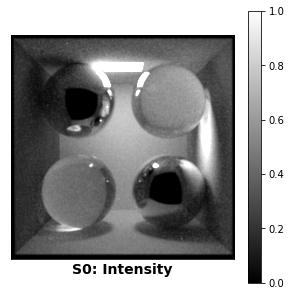

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(s0**(1/2.2), cmap='gray', vmin=0, vmax=1) # TODO: correct linear -> sRGB conversion
plt.colorbar()
plt.xticks([]); plt.yticks([])
plt.xlabel("S0: Intensity", size=14, weight='bold')
plt.show()

For the three Stokes vector components that encode the polarization state, we use a divergent colormap (`coolwarm`) as there are both positive and negative values to be displayed.

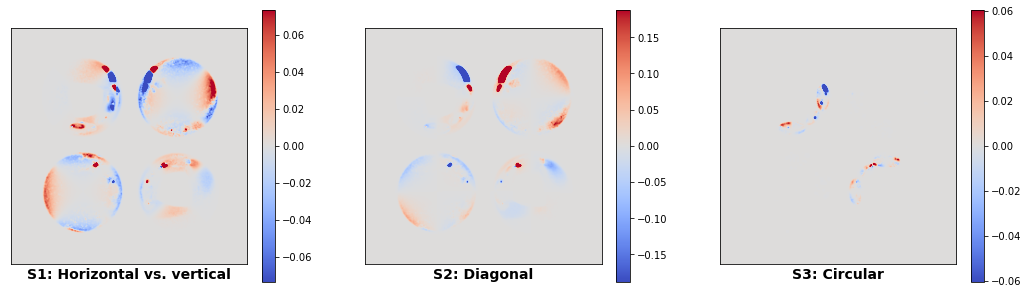

In [9]:
def plot_stokes_component(ax, data):
    plot_minmax = 0.05*max(np.max(data), np.max(-data)) # Arbitrary scale for colormap
    img = ax.imshow(data, cmap='coolwarm', vmin=-plot_minmax, vmax=+plot_minmax)
    ax.set_xticks([]); ax.set_yticks([])
    return img
    
    
fig, ax = plt.subplots(ncols=3, figsize=(18, 5))
img = plot_stokes_component(ax[0], s1)
plt.colorbar(img, ax=ax[0])
img = plot_stokes_component(ax[1], s2)
plt.colorbar(img, ax=ax[1])
img = plot_stokes_component(ax[2], s3)
plt.colorbar(img, ax=ax[2])

ax[0].set_xlabel("S1: Horizontal vs. vertical", size=14, weight='bold')
ax[1].set_xlabel("S2: Diagonal", size=14, weight='bold')
ax[2].set_xlabel("S3: Circular", size=14, weight='bold')

plt.show()

### Bonus step - standard visualizations for polarization

Mitsuba 2 additionally ships with a command line tool that implements the paper ["A Standardised Polarisation Visualisation for Images" by Wilkie and Weidlich]("https://cgg.mff.cuni.cz/~wilkie/Website/Home_files/polvis_sccg_2010.pdf). This can be used to produce many more interesting false-color visualizations in this style automatically from these multi-channel Stokes vector images.

The tool can be run with:
```
python3 -m mitsuba.python.polvis
```
Please see the corresponding help text and the paper for more details.

---

You now know the basics of how to render images in Mitsuba 2 that include additional polarization information. 🕶

### *Reference API*

- [<code>mitsuba.set_variant</code>](https://mitsuba2.readthedocs.io/en/latest/generated/core_api.html#mitsuba.set_variant)
- [<code>mitsuba.load_file</code>](https://mitsuba2.readthedocs.io/en/latest/generated/core_api.html#mitsuba.core.load_file)
- [<code>mitsuba.python.util.render</code>](https://mitsuba2.readthedocs.io/en/latest/generated/python_api.html#mitsuba.python.util.render)
- [<code>mitsuba.render.Film</code>](https://mitsuba2.readthedocs.io/en/latest/generated/render_api.html#film)